# Imports

In [1]:
# Planetary computer Search
from pystac_client import Client
import planetary_computer as pc

# DataFrames - Read and Write
import pandas as pd
import numpy as np
import geopandas as gpd

# Raster Operations
import rioxarray as rxr
from xrspatial.zonal import stats

# Raster Visualization (xArray can be used but computation heavy) 
import rasterio
from rasterio import windows
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Load Boundary data

In [2]:
def set_projection(geo_df, projection=4326):
    current_crs = geo_df.crs 
    if current_crs == projection :
        return geo_df 
    else : 
        geo_df = geo_df.to_crs(projection)
        return geo_df

In [3]:
delhi_subdistricts = gpd.read_file('delhi.gpkg')
delhi_subdistricts = set_projection(delhi_subdistricts, 4236)

In [4]:
# set this as defalt CRS, this CRS will be used for all data
def_crs = delhi_subdistricts.crs
def_crs

<Geographic 2D CRS: EPSG:4236>
Name: Hu Tzu Shan 1950
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: Taiwan, Republic of China - onshore - Taiwan Island, Penghu (Pescadores) Islands.
- bounds: (119.25, 21.87, 122.06, 25.34)
Datum: Hu Tzu Shan 1950
- Ellipsoid: International 1924
- Prime Meridian: Greenwich

In [5]:
# get bounding box around delhi region. 
# This values will be ised to query the Planetary computer data catalog
delhi = delhi_subdistricts.dissolve()
bounds_df = delhi.bounds.squeeze()
bounds = [bounds_df['minx'], bounds_df['miny'], bounds_df['maxx'], bounds_df['maxy']]
bounds

[76.83461423721083, 28.403779875756772, 77.34290225567445, 28.882642229911685]

# Query for Landcover (raster)

In [6]:
catalog = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

search = catalog.search(collections=["esa-worldcover"], bbox=bounds)

items = list(search.get_items())
print(f"Returned {len(items)} Items")

Returned 1 Items


In [7]:
asset_href = items[0].assets["map"].href
print(asset_href)

https://ai4edataeuwest.blob.core.windows.net/esa-worldcover/v100/2020/map/ESA_WorldCover_10m_2020_v100_N27E075_Map.tif


In [8]:
signed_href = pc.sign(asset_href)

# Landcover visualization 

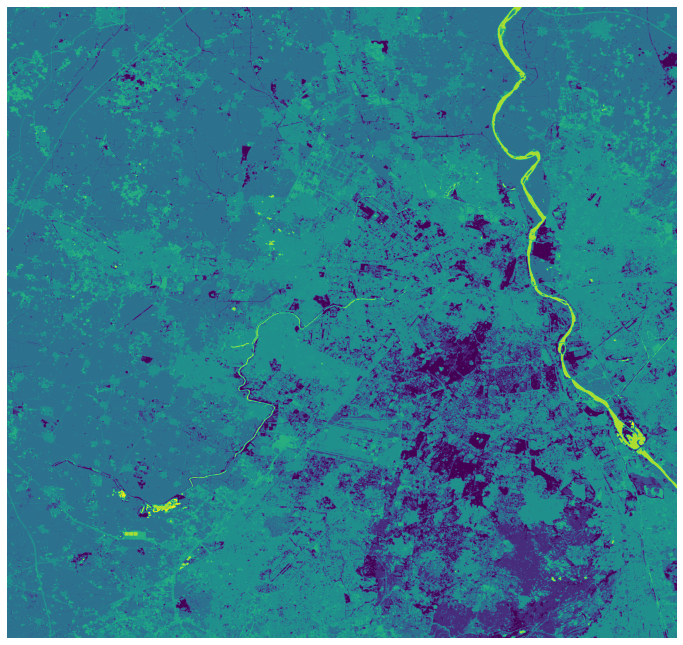

In [9]:
with rasterio.open(signed_href) as src:
    aoi_window = windows.from_bounds(transform=src.transform, *bounds)
    raster_data = src.read(1, window=aoi_window)

fig, ax = plt.subplots(figsize=(12, 12))

ax.set_axis_off()
ax.imshow(raster_data);

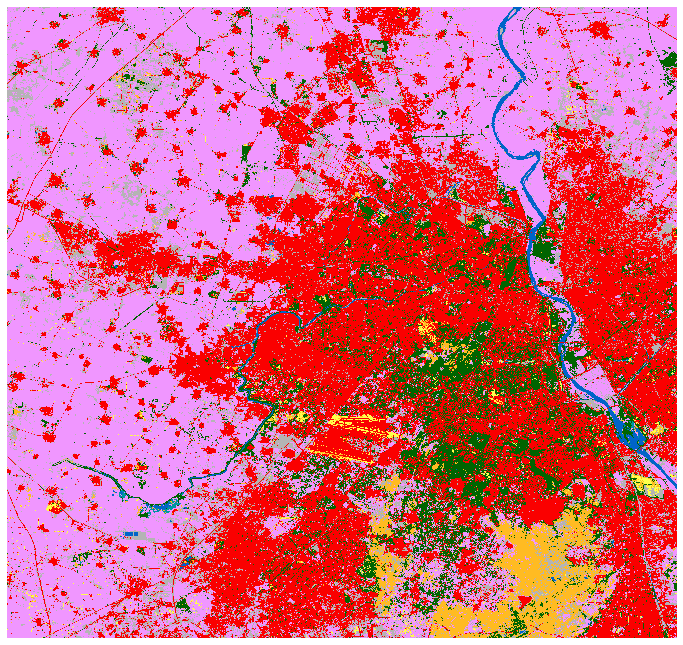

In [10]:
with rasterio.open(signed_href) as src:
    colormap_def = src.colormap(1)
    colormap = [np.array(colormap_def[i]) / 255 for i in range(len(colormap_def))]

cmap = ListedColormap(colormap)
fig, ax = plt.subplots(figsize=(12, 12))

ax.set_axis_off()
ax.imshow(raster_data, cmap=cmap, vmin=0,  vmax=(len(colormap_def) - 1),  interpolation="nearest");

# Converting to xArray DataFrame for computation

In [11]:
delhi_landcover = rxr.open_rasterio(signed_href)
delhi_landcover

<xarray.DataArray (band: 1, y: 36000, x: 36000)>
[1296000000 values with dtype=uint8]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 75.0 75.0 75.0 75.0 75.0 ... 78.0 78.0 78.0 78.0
  * y            (y) float64 30.0 30.0 30.0 30.0 30.0 ... 27.0 27.0 27.0 27.0
    spatial_ref  int64 0
Attributes:
    _FillValue:    0.0
    scale_factor:  1.0
    add_offset:    0.0

In [12]:
delhi_landcover_clipped = delhi_landcover.rio.clip(delhi.geometry.values, def_crs)

In [13]:
delhi_landcover_clipped.rio.to_raster("delhi_landcover_clipped.tif")

# Landcover area computation. 

Area should be in metric units, so we have to re-project our data's to any Projected coordinate system. 

``EPSG:32643``  is a good option since we are working in delhi region falls in UTM 43N. Lets re-project our data to this CRS

In [14]:
# Reproject boundary file and get 32643 WRK File 
delhi_subdistricts_projected = set_projection(delhi_subdistricts, 32643)
reproject_crs = delhi_subdistricts_projected.crs
print(reproject_crs)
# To get the pixel resolution
delhi_landcover_clipped_projected = delhi_landcover_clipped.rio.reproject(reproject_crs)

epsg:32643


In [15]:
# Compute the Pixel size to compute ara 
x_res = abs(delhi_landcover_clipped_projected.rio.resolution()[0])
y_res = abs(delhi_landcover_clipped_projected.rio.resolution()[1])
print(x_res, y_res)

8.677247770294063 8.677247770294063


In [ ]:
concatList = []
for _, sub_district in delhi_subdistricts_projected.iterrows():
    shape_geom = sub_district['geometry']
    raster = delhi_landcover_clipped_projected.rio.clip(shape_geom, reproject_crs)
    stats_df = stats(zones=raster[0], values=raster[0])
    stats_df['area_km'] = stats_df['count']*x_res*y_res/1000000
    stats_df['area_km'] = stats_df['area_km'].round(decimals= 2)
    stats_df = stats_df[['zone', 'area_km']].set_index('zone').drop(0).transpose()
    stats_df['sub_district'] = sub_district['NAME']
    concatList.append(stats_df)
area_df = pd.concat(concatList)
area_df = area_df.set_index('sub_district')

In [24]:
calss_values = {
  10: "Trees",
  20: "Shrubland",
  30: "Grassland",
  40: "Cropland",
  50: "Built-up",
  60: "Barren / sparse vegetation",
  70: "Snow and ice",
  80: "Open water",
  90: "Herbaceous wetland",
  95: "Mangroves",
  100: "Moss and lichen"
}

In [25]:
area_df = area_df.rename(columns=calss_values).sort_index()
area_df.head()

zone,Trees,Shrubland,Grassland,Cropland,Built-up,Barren / sparse vegetation,Open water,Herbaceous wetland
sub_district,,,,,,,,
Chanakya Puri,10.72,0.25,0.55,0.35,7.50,0.49,0.01,NaN
Civil Lines,10.04,0.35,0.21,16.63,23.30,4.79,3.86,0.00
Connaught Place,5.63,0.01,0.15,0.69,5.42,0.79,0.61,0.00
Darya Ganj,2.36,0.03,0.16,0.84,3.88,0.54,0.40,NaN
Defence Colony,12.00,0.28,0.66,4.84,25.47,3.82,4.23,0.12


# Export the csv file with area value for each category

In [26]:
area_df.to_csv('delhi_landcover_area_sqkm_pccompute.csv')